# Import Libraries

In [1]:
import ta
import requests
import numpy as np
import pandas as pd
import yfinance as yf
import FinanceDataReader as fdr
import pandas_datareader as pdr
import matplotlib.pyplot as plt
import seaborn as sns
from yahooquery import Ticker
from fredapi import Fred
from datetime import datetime
from bs4 import BeautifulSoup
from pandas_datareader import data as pdr
from statsmodels.tsa.holtwinters import ExponentialSmoothing

import datetime as dt
import tensorflow as tf
import matplotlib.dates as mdates
import xgboost as xgb
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, learning_curve
from keras.regularizers import L1L2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
import warnings

warnings.filterwarnings('ignore', category=UserWarning)

today = datetime.today().strftime('%Y-%m-%d')

# 주가예측을 위한 범위 설정

In [2]:
symbol=input("예측할 종목(symbol)을 입력해주세요")

예측할 종목(symbol)을 입력해주세요 nvda


In [3]:
ticker = symbol 
start_date = '2013-10-28'
end_date = today

# 데이터 준비

## 1. Technical data - 주가 데이터 수집 및 보조지표 추가

In [4]:
stock_df = yf.download(ticker, start = start_date, end = end_date)

## 1.1. Simple Moving Average (SMA)
stock_df['MA5'] = stock_df['Adj Close'].rolling(window=5).mean()        # 5일 SMA
stock_df['MA20'] = stock_df['Adj Close'].rolling(window=20).mean()      # 20일 SMA
stock_df['MA60'] = stock_df['Adj Close'].rolling(window=60).mean()      # 60일 SMA
stock_df['MA120'] = stock_df['Adj Close'].rolling(window=120).mean()    # 120일 SMA

## 1.2. Exponential Moving Average (EMA)
stock_df['EMA5'] = stock_df['Adj Close'].ewm(span=5, adjust=False).mean()       # 5일 EMA
stock_df['EMA20'] = stock_df['Adj Close'].ewm(span=20, adjust=False).mean()     # 20일 EMA
stock_df['EMA60'] = stock_df['Adj Close'].ewm(span=60, adjust=False).mean()     # 60일 EMA
stock_df['EMA120'] = stock_df['Adj Close'].ewm(span=120, adjust=False).mean()   # 120일 EMA

## 1.3. Double Bollinger Bands indicator

# Central Line (20-day moving average)
stock_df['BOL_AVG'] = ta.volatility.bollinger_mavg(stock_df['Adj Close'])

# Double Bollinger Bands
stock_df['BOL_H1'] = stock_df['BOL_AVG'] + 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L1'] = stock_df['BOL_AVG'] - 2 * stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_H2'] = stock_df['BOL_AVG'] + stock_df['Adj Close'].rolling(window=20).std()
stock_df['BOL_L2'] = stock_df['BOL_AVG'] - stock_df['Adj Close'].rolling(window=20).std()

## 1.4. Relative Strength Index (RSI)
stock_df['RSI'] = ta.momentum.rsi(stock_df['Adj Close'])

## 1.5. Moving Average Convergence Divergence (MACD)
stock_df['MACD'] = ta.trend.macd(stock_df['Adj Close'])
stock_df['MACD_SIGNAL']= ta.trend.macd_signal(stock_df['Adj Close'])

## 1.6. On-Balance Volume (OBV)
stock_df['OBV'] = ta.volume.on_balance_volume(stock_df['Adj Close'], stock_df['Volume'])

stock_df

[*********************100%%**********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume,MA5,MA20,MA60,MA120,...,EMA120,BOL_AVG,BOL_H1,BOL_L1,BOL_H2,BOL_L2,RSI,MACD,MACD_SIGNAL,OBV
Date,,,,,,,,,,,,,,,,,,,,,
2013-10-28,3.805000,3.822500,3.750000,3.802500,3.567924,39402400,NaN,NaN,NaN,NaN,...,3.567924,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,39402400
2013-10-29,3.797500,3.815000,3.762500,3.807500,3.572614,38795200,NaN,NaN,NaN,NaN,...,3.568002,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78197600
2013-10-30,3.820000,3.837500,3.772500,3.805000,3.570269,20403200,NaN,NaN,NaN,NaN,...,3.568039,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,57794400
2013-10-31,3.810000,3.837500,3.790000,3.797500,3.563232,29336800,NaN,NaN,NaN,NaN,...,3.567960,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28457600
2013-11-01,3.817500,3.832500,3.787500,3.815000,3.579652,20613600,3.570738,NaN,NaN,NaN,...,3.568153,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,49071200
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15,869.299988,895.460022,862.570007,878.369995,878.369995,64019300,888.712000,824.076584,665.385037,560.953477,...,605.573367,824.076584,969.079425,679.073742,896.578005,751.575163,63.274329,58.002967,59.938639,11034012200
2024-03-18,903.880005,924.049988,870.849976,884.549988,884.549988,66897600,894.073999,831.999286,671.860591,564.806701,...,610.184550,831.999286,971.678699,692.319873,901.838992,762.159579,64.045119,55.367929,59.024497,11100909800
2024-03-19,867.000000,905.440002,850.099976,893.979980,893.979980,67217100,889.043994,841.973914,678.742134,568.764422,...,614.875384,841.973914,968.145341,715.802486,905.059627,778.888200,65.243807,53.424717,57.904541,11168126900


## 2. Fundamental data - 경제지표 불러오기


In [5]:
adj_close_df = stock_df[['Adj Close']]

## 2.1. U.S. Treasury bond yields 
fred = Fred(api_key = '4c55d0ee6170369793707da4cba1b7be')
dgs2 = fred.get_series('DGS2', observation_start=start_date, observation_end=end_date)      # 2년 DGS
dgs5 = fred.get_series('DGS5', observation_start=start_date, observation_end=end_date)      # 5년 DGS
dgs10 = fred.get_series('DGS10', observation_start=start_date, observation_end=end_date)    # 10년 DGS

DGS = pd.concat([dgs2, dgs5,dgs10], axis=1)
DGS.columns = ['2-year', '5-year', '10-year']
DGS.index.name = 'Date'

## 2.2. U.S. long-short interest rate spread (10-year & 2-year)
T10Y2Y = fdr.DataReader('FRED:T10Y2Y', start_date, end_date)
T10Y2Y.index.name = 'Date'

## 2.3. Volatility Index (VIX)
VIX = fdr.DataReader('FRED:VIXCLS', start_date, end_date)
VIX.index.name = 'Date'

## 2.4. Unemployment Rate
Unemployment_Rate = fdr.DataReader('FRED:UNRATE', start_date, end_date)
Unemployment_Rate.index.name = 'Date'

## 2.5. Consumer Price Index (CPI)
CPI = fdr.DataReader('FRED:CPIAUCSL', start_date, end_date)
CPI.index.name = 'Date'

## 2.6. Federal funds rate
FEDFUNDS = fdr.DataReader('FRED:FEDFUNDS', start_date, end_date)
FEDFUNDS.index.name = 'Date'

## 2.7. Gross Domestic Product (GDP)
GDP = pd.DataFrame(fred.get_series('GDP',observation_start=start_date, observation_end = end_date),columns=['GDP'])
GDP.index.name = 'Date'

## Interpolation and Holt-Winters' Exponential Smoothing 

# DGS
# Linear interpolation up to the last date of the data
itp_df = DGS.resample('D').asfreq() 
itp_df = itp_df.interpolate(method='linear') 

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
stock_end_date = stock_df.index[-1]
forecast_steps = (pd.to_datetime(stock_end_date) - itp_df.index[-1]).days   
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal=None).fit() # Holt-Winters' Exponential Smoothing
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

int_DGS = pd.concat([itp_df, forecast_df])

# Unemployment Rate
# Linear interpolation up to the last date of the data
itp_unrate = Unemployment_Rate.resample('D').asfreq()
itp_unrate = itp_unrate.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_unrate = (pd.to_datetime(stock_end_date) - itp_unrate.index[-1]).days 
forecast_df_unrate = pd.DataFrame(index=pd.date_range(itp_unrate.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_unrate = ExponentialSmoothing(itp_unrate['UNRATE'], trend='add', seasonal=None).fit()
forecast_unrate = model_unrate.forecast(steps=forecast_steps_unrate)
forecast_df_unrate['UNRATE'] = forecast_unrate

int_Unemployment_Rate = pd.concat([itp_unrate, forecast_df_unrate])

# CPI
# Linear interpolation up to the last date of the data
itp_CPI = CPI.resample('D').asfreq()
itp_CPI = itp_CPI.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_CPI = (pd.to_datetime(stock_end_date) - itp_CPI.index[-1]).days 
forecast_df_CPI = pd.DataFrame(index=pd.date_range(itp_CPI.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_unrate = ExponentialSmoothing(itp_CPI['CPIAUCSL'], trend='add', seasonal=None).fit()
forecast_unrate = model_unrate.forecast(steps=forecast_steps_CPI)
forecast_df_CPI['CPIAUCSL'] = forecast_unrate

int_CPI = pd.concat([itp_CPI, forecast_df_CPI])

# FEDFUNDs
# Linear interpolation up to the last date of the data
itp_fedfunds = FEDFUNDS.resample('D').asfreq()
itp_fedfunds = itp_fedfunds.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_fedfunds = (pd.to_datetime(stock_end_date) - itp_fedfunds.index[-1]).days + 1
forecast_df_fedfunds = pd.DataFrame(index=pd.date_range(itp_fedfunds.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_fedfunds = ExponentialSmoothing(itp_fedfunds['FEDFUNDS'], trend='add', seasonal=None).fit()
forecast_fedfunds = model_fedfunds.forecast(steps=forecast_steps_fedfunds)
forecast_df_fedfunds['FEDFUNDS'] = forecast_fedfunds

itp_FEDFUNDS = pd.concat([itp_fedfunds, forecast_df_fedfunds])

# GDP
# Linear interpolation up to the last date of the data
itp_gdp = GDP.resample('D').asfreq()
itp_gdp = itp_gdp.interpolate()

# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps_gdp = (pd.to_datetime(stock_end_date) - itp_gdp.index[-1]).days 
forecast_df_gdp = pd.DataFrame(index=pd.date_range(itp_gdp.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

model_gdp = ExponentialSmoothing(itp_gdp['GDP'], trend='add', seasonal='add', seasonal_periods=4).fit()
forecast_gdp = model_gdp.forecast(steps=forecast_steps_gdp)
forecast_df_gdp['GDP'] = forecast_gdp

itp_GDP = pd.concat([itp_gdp, forecast_df_gdp])

econ_df = adj_close_df.join([int_DGS, T10Y2Y, VIX, int_Unemployment_Rate, int_CPI, itp_FEDFUNDS, itp_GDP ], how='left')

econ_df

,Adj Close,2-year,5-year,10-year,T10Y2Y,VIXCLS,UNRATE,CPIAUCSL,FEDFUNDS,GDP
Date,,,,,,,,,,
2013-10-28,3.567924,0.320000,1.310000,2.540000,2.22,13.31,6.938710,234.044387,0.081290,17193.697402
2013-10-29,3.572614,0.310000,1.290000,2.530000,2.22,13.41,6.929032,234.058290,0.080968,17193.759565
2013-10-30,3.570269,0.330000,1.300000,2.550000,2.22,13.65,6.919355,234.072194,0.080645,17193.821728
2013-10-31,3.563232,0.310000,1.310000,2.570000,2.26,13.75,6.909677,234.086097,0.080323,17193.883891
2013-11-01,3.579652,0.330000,1.370000,2.650000,2.32,13.28,6.900000,234.100000,0.080000,17193.946054
...,...,...,...,...,...,...,...,...,...,...
2024-03-15,878.369995,4.720000,4.330000,4.310000,-0.41,14.41,4.177419,312.952935,5.330000,28549.006419
2024-03-18,884.549988,4.730000,4.360000,4.340000,-0.39,14.33,4.196774,313.085419,5.330000,28559.945716
2024-03-19,893.979980,4.680000,4.310000,4.300000,-0.38,13.82,4.203226,313.129581,5.330000,28563.570310


## 3. Fundamental data - 산업지표 불러오기

In [6]:
# Yahoo Finance 라이브러리를 사용하여 각종 지수 및 ETF 데이터를 가져옵니다.
yf.pdr_override() 

# 다우존스 지수 데이터 가져오기
df = pdr.get_data_yahoo("^DJI", start=start_date, end=end_date) # Dow Jones

# 나스닥 지수 데이터 가져오기
df1 = pdr.get_data_yahoo("NDAQ", start=start_date, end=end_date) # NASDAQ

# S&P500 지수 데이터 가져오기
df2 = pdr.get_data_yahoo("^SPX", start=start_date, end=end_date) # S&P500

# Russell 2000 지수 데이터 가져오기
df3 = pdr.get_data_yahoo("^RUT", start=start_date, end=end_date) # Russell 2000

# 컬럼 이름 변경
df.rename(columns={'Adj Close': 'DJI Adj Close', 'Volume': 'DJI Volume'}, inplace=True) 
df1.rename(columns={'Adj Close': 'NDAQ Adj Close', 'Volume': 'NDAQ Volume'}, inplace=True)
df2.rename(columns={'Adj Close': 'SPX Adj Close', 'Volume': 'SPX Volume'}, inplace=True)
df3.rename(columns={'Adj Close': 'RUT Adj Close', 'Volume': 'RUT Volume'}, inplace=True)

# 필요한 컬럼만 선택
df = df[['DJI Adj Close', 'DJI Volume']] 
df1 = df1[['NDAQ Adj Close', 'NDAQ Volume']]
df2 = df2[['SPX Adj Close', 'SPX Volume']]
df3 = df3[['RUT Adj Close', 'RUT Volume']]

# 모든 지수 데이터 결합
Index_data = pd.concat([df, df1, df2, df3], axis=1, join='outer')

# 주식 데이터와 결합
Index_data = Index_data.join(stock_df['Adj Close'], how='left')

# ETF 기반 업종 데이터 가져오기
sectors = {
    "VDE": "Energy",                 # 에너지
    "MXI": "Materials",              # 소재
    "VIS": "Industrials",            # 산업재
    "VCR": "Consumer Cyclical",      # 소비자 경기주
    "XLP": "Consumer Staples",       # 소비자 방어주
    "VHT": "Health Care",            # 의료
    "XLF": "Financials",             # 금융
    "VGT": "Information Technology", # IT
    "VOX": "Communication Services", # 통신
    "XLU": "Utilities",              # 공공서비스
    "VNQ": "Real Estate"             # 부동산
}

sector_data = {}

# ETF 기반 업종 데이터를 가져오고 컬럼 이름을 변경하여 저장
for sector, sector_name in sectors.items():
    data = yf.download(sector, start=start_date, end=end_date)
    data.rename(columns={
        'Adj Close': f'{sector_name} Adj Close',
        'Volume': f'{sector_name} Volume'
    }, inplace=True) 
    sector_data[sector] = data[[f'{sector_name} Adj Close', f'{sector_name} Volume']]
    
ETF = pd.concat(sector_data.values(), axis=1)

# 입력된 주식 종목의 업종에 해당하는 ETF 데이터를 선택하여 가져옵니다.
sector = yf.Ticker(ticker).info.get('sector', None)
sector_columns = [col for col in ETF.columns if sector in col] 
sector_df = ETF[sector_columns]

# 업종 데이터와 결합하여 최종 데이터 프레임 생성
Industry_df = Index_data.merge(sector_df, on="Date", how="inner")

Industry_df


[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%*******

,DJI Adj Close,DJI Volume,NDAQ Adj Close,NDAQ Volume,SPX Adj Close,SPX Volume,RUT Adj Close,RUT Volume,Adj Close,Information Technology Adj Close,Information Technology Volume
Date,,,,,,,,,,,
2013-10-28,15568.929688,92760000,10.016082,3717300,1762.109985,3282300000,1117.969971,3282300000,3.567924,75.289032,144300
2013-10-29,15680.349609,86600000,10.097403,4114500,1771.949951,3358460000,1121.069946,3358460000,3.572614,75.666397,189100
2013-10-30,15618.759766,79170000,10.018888,2375700,1763.310059,3523040000,1105.500000,3523040000,3.570269,75.324989,175300
2013-10-31,15545.750000,114050000,9.934765,3497700,1756.540039,3826530000,1100.150024,3826530000,3.563232,75.145325,208000
2013-11-01,15615.549805,101830000,9.898314,3770100,1761.640015,3686290000,1095.670044,3686290000,3.579652,75.190231,174900
...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15,38714.769531,774360000,59.680000,3527300,5117.089844,7753670000,2039.319946,7753670000,878.369995,515.559998,474000
2024-03-18,38790.429688,327950000,60.290001,3320600,5149.419922,4036220000,2024.739990,4036220000,884.549988,517.979980,320900
2024-03-19,39110.761719,310610000,62.459999,5250100,5178.509766,4031760000,2035.709961,4031760000,893.979980,520.169983,360100


## 4. Fundamental data - 기업 재무제표 불러오기

In [7]:
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/89.0.4389.82 Safari/537.36'
}

## 4.1. INCOME STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Income_df = pd.read_html(str(element_tables))[0] 
Income_df.to_csv(ticker+'.csv', index=False)

FS_Income = Income_df.transpose()
FS_Income.columns = FS_Income.iloc[0]
FS_Income = Income_df.set_index("Quarter Ended").transpose()
FS_Income.index.name = "Date"
FS_Income.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Income = FS_Income.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Income.columns:
    if FS_Income[column].dtype == 'object':
        FS_Income[column] = FS_Income[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Income[column].dtype == 'object' and FS_Income[column].str.contains('%').any():
            FS_Income[column] = FS_Income[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign
        FS_Income[column] = pd.to_numeric(FS_Income[column], errors='coerce')   # Converting other strings to numbers
        
## 4.2. RATIO STATEMENT
url = f"https://stockanalysis.com/stocks/{ticker}/financials/ratios/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Ratio_df = pd.read_html(str(element_tables))[0]
Ratio_df.to_csv(ticker+'.csv', index=False)

FS_Ratio = Ratio_df.transpose()
FS_Ratio.columns = FS_Ratio.iloc[0]
FS_Ratio = Ratio_df.set_index("Quarter Ended").transpose()
FS_Ratio.index.name = "Date"
FS_Ratio.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Ratio = FS_Ratio.iloc[1:-1, :]

# Convert string to numeric type
for column in FS_Ratio.columns:
    if FS_Ratio[column].dtype == 'object':       
        FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Ratio[column].dtype == 'object' and FS_Ratio[column].str.contains('%').any():
            FS_Ratio[column] = FS_Ratio[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Ratio[column] = pd.to_numeric(FS_Ratio[column], errors='coerce') # Converting other strings to numbers

## 4.3. Balance Sheet
url = f"https://stockanalysis.com/stocks/{ticker}/financials/balance-sheet/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Balance_df = pd.read_html(str(element_tables))[0] 
Balance_df.to_csv(ticker+'.csv', index=False)

FS_Balance = Balance_df.transpose()
FS_Balance.columns = FS_Balance.iloc[0]
FS_Balance = Balance_df.set_index("Quarter Ended").transpose()
FS_Balance.index.name = "Date"
FS_Balance.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Balance = FS_Balance.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Balance.columns:
    if FS_Balance[column].dtype == 'object':       
        FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)    # Converting strings with numbers after '-'
        if FS_Balance[column].dtype == 'object' and FS_Balance[column].str.contains('%').any():
            FS_Balance[column] = FS_Balance[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x) # Converting strings with a percentage sign
        FS_Balance[column] = pd.to_numeric(FS_Balance[column], errors='coerce') # Converting other strings to numbers

## 4.4. Cash Flow
url = f"https://stockanalysis.com/stocks/{ticker}/financials/cash-flow-statement/?p=quarterly" 
response = requests.get(url, headers=headers)
soup = BeautifulSoup(response.content, 'html.parser')
element_tables = soup.select("table[data-test='financials']")

Cash_df = pd.read_html(str(element_tables))[0] 
Cash_df.to_csv(ticker+'.csv', index=False)

FS_Cash = Cash_df.transpose()
FS_Cash.columns = FS_Cash.iloc[0]
FS_Cash = Cash_df.set_index("Quarter Ended").transpose()
FS_Cash.index.name = "Date"
FS_Cash.to_csv(ticker+'.csv', index=True, encoding='euc-kr')
FS_Cash = FS_Cash.iloc[:-1, :]

# Convert string to numeric type
for column in FS_Cash.columns:
    if FS_Cash[column].dtype == 'object':       
        FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x) if '-' in x and x[1:].isdigit() else x)  # Converting strings with numbers after '-'
        if FS_Cash[column].dtype == 'object' and FS_Cash[column].str.contains('%').any():
            FS_Cash[column] = FS_Cash[column].apply(lambda x: float(x.replace('%', '')) / 100 if '%' in x else x)   # Converting strings with a percentage sign       
        FS_Cash[column] = pd.to_numeric(FS_Cash[column], errors='coerce')   # Converting other strings to numbers

C:\Users\user\AppData\Local\Temp\ipykernel_13532\4235770813.py:11: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  Income_df = pd.read_html(str(element_tables))[0]
C:\Users\user\AppData\Local\Temp\ipykernel_13532\4235770813.py:35: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  Ratio_df = pd.read_html(str(element_tables))[0]
C:\Users\user\AppData\Local\Temp\ipykernel_13532\4235770813.py:59: FutureWarning: Passing literal html to 'read_html' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  Balance_df = pd.read_html(str(element_tables))[0]
C:\Users\user\AppData\Local\Temp\ipykernel_13532\4235770813.py:83: FutureWarning: Passing literal html to 'read_html' is deprecated and wil

## 4.2. 재무제표 요약 데이터 생성

In [8]:
# Add ROE (Return on Equity)
FS_Ratio['ROE'] = FS_Income['Net Income'] / FS_Balance['Shareholders\' Equity']

# Merge all financial statement data
FS_Summary = pd.concat([FS_Income, FS_Balance, FS_Ratio, FS_Cash], axis=1)
FS_Summary.index = pd.to_datetime(FS_Summary.index)
duplicated_columns = FS_Summary.columns[FS_Summary.columns.duplicated()].unique()
FS_Summary = FS_Summary.drop(columns=duplicated_columns)

## Interpolation and Holt-Winters' Exponential Smoothing for Monthly Data

# Linear interpolation up to the last date of the data
itp_df = FS_Summary.resample('D').asfreq() 
for column in itp_df.columns:
    itp_df[column] = itp_df[column].interpolate(method='linear') # using linear method
    
# Holt-Winters' Exponential Smoothing: Forecasting from the last date in provided data to the desired End Date
forecast_steps = (pd.to_datetime(stock_end_date) - itp_df.index[-1]).days
forecast_df = pd.DataFrame(index=pd.date_range(itp_df.index[-1] + pd.Timedelta(days=1), stock_end_date)) 

for column in itp_df.columns:
    model = ExponentialSmoothing(itp_df[column], trend='add', seasonal= None, seasonal_periods=4).fit() 
    forecast = model.forecast(steps=forecast_steps)
    forecast_df[column] = forecast

daily_FS_Summary = pd.concat([itp_df, forecast_df])
daily_FS_Summary = daily_FS_Summary.dropna(axis=1, how='any')

# Add Adj Close
daily_FS_Summary = daily_FS_Summary.merge(adj_close_df, left_index=True, right_index=True, how='left')
daily_FS_Summary = daily_FS_Summary.dropna()
daily_FS_Summary['Date'] = daily_FS_Summary.index
daily_FS_Summary = daily_FS_Summary.reset_index(drop=True)
daily_FS_Summary = daily_FS_Summary.set_index('Date').sort_index()

# Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
daily_FS_Summary= daily_FS_Summary[selected_features]

daily_FS_Summary

,Revenue,Cost of Revenue,Gross Profit,Operating Income,Pretax Income,EPS (Basic),EPS (Diluted),EBITDA,EBIT,Receivables,...,Other Long-Term Assets,Total Assets,Other Current Liabilities,Other Long-Term Liabilities,Shareholders' Equity,Book Value Per Share,Market Capitalization,Enterprise Value,Operating Cash Flow,Adj Close
Date,,,,,,,,,,,,,,,,,,,,,
2014-04-28,1103.000000,498.835165,604.164835,151.131868,162.912088,0.060000,0.060000,228.934066,173.923077,397.244286,...,99.306923,6865.758242,589.139560,419.268242,4168.516484,1.860769,1.037600e+04,7.407648e+03,150.395604,4.418425
2014-04-29,1103.000000,498.670330,604.329670,151.263736,162.824176,0.060000,0.060000,228.868132,173.846154,398.048571,...,99.263846,6866.516484,589.339121,418.766484,4170.032967,1.861538,1.037100e+04,7.402297e+03,149.791209,4.427900
2014-04-30,1103.000000,498.505495,604.494505,151.395604,162.736264,0.060000,0.060000,228.802198,173.769231,398.852857,...,99.220769,6867.274725,589.538681,418.264725,4171.549451,1.862308,1.036600e+04,7.396945e+03,149.186813,4.375779
2014-05-01,1103.000000,498.340659,604.659341,151.527473,162.648352,0.060000,0.060000,228.736264,173.692308,399.657143,...,99.177692,6868.032967,589.738242,417.762967,4173.065934,1.863077,1.036100e+04,7.391593e+03,148.582418,4.399470
2014-05-02,1103.000000,498.175824,604.824176,151.659341,162.560440,0.060000,0.060000,228.670330,173.615385,400.461429,...,99.134615,6868.791209,589.937802,417.261209,4174.582418,1.863846,1.035600e+04,7.386242e+03,147.978022,4.366302
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-03-15,24160.153846,5617.758242,18542.395604,15265.197802,15957.076923,5.615275,5.544945,16414.824176,16020.076923,10871.857143,...,10545.879121,71708.879121,7306.945055,2699.560440,47994.604396,19.470110,1.769383e+06,1.750265e+06,13651.186813,878.369995
2024-03-18,24291.461538,5637.274725,18654.186813,15370.593407,16075.230769,5.655824,5.584835,16533.472527,16138.230769,10927.571429,...,10543.637363,72090.637363,7346.835165,2709.681319,48314.813187,19.600330,1.786101e+06,1.766730e+06,13788.560440,884.549988
2024-03-19,24335.230769,5643.780220,18691.450549,15405.725275,16114.615385,5.669341,5.598132,16573.021978,16177.615385,10946.142857,...,10542.890110,72217.890110,7360.131868,2713.054945,48421.549451,19.643736,1.791674e+06,1.772218e+06,13834.351648,893.979980


## 보간법을 진행한 변수들 시각화 확인


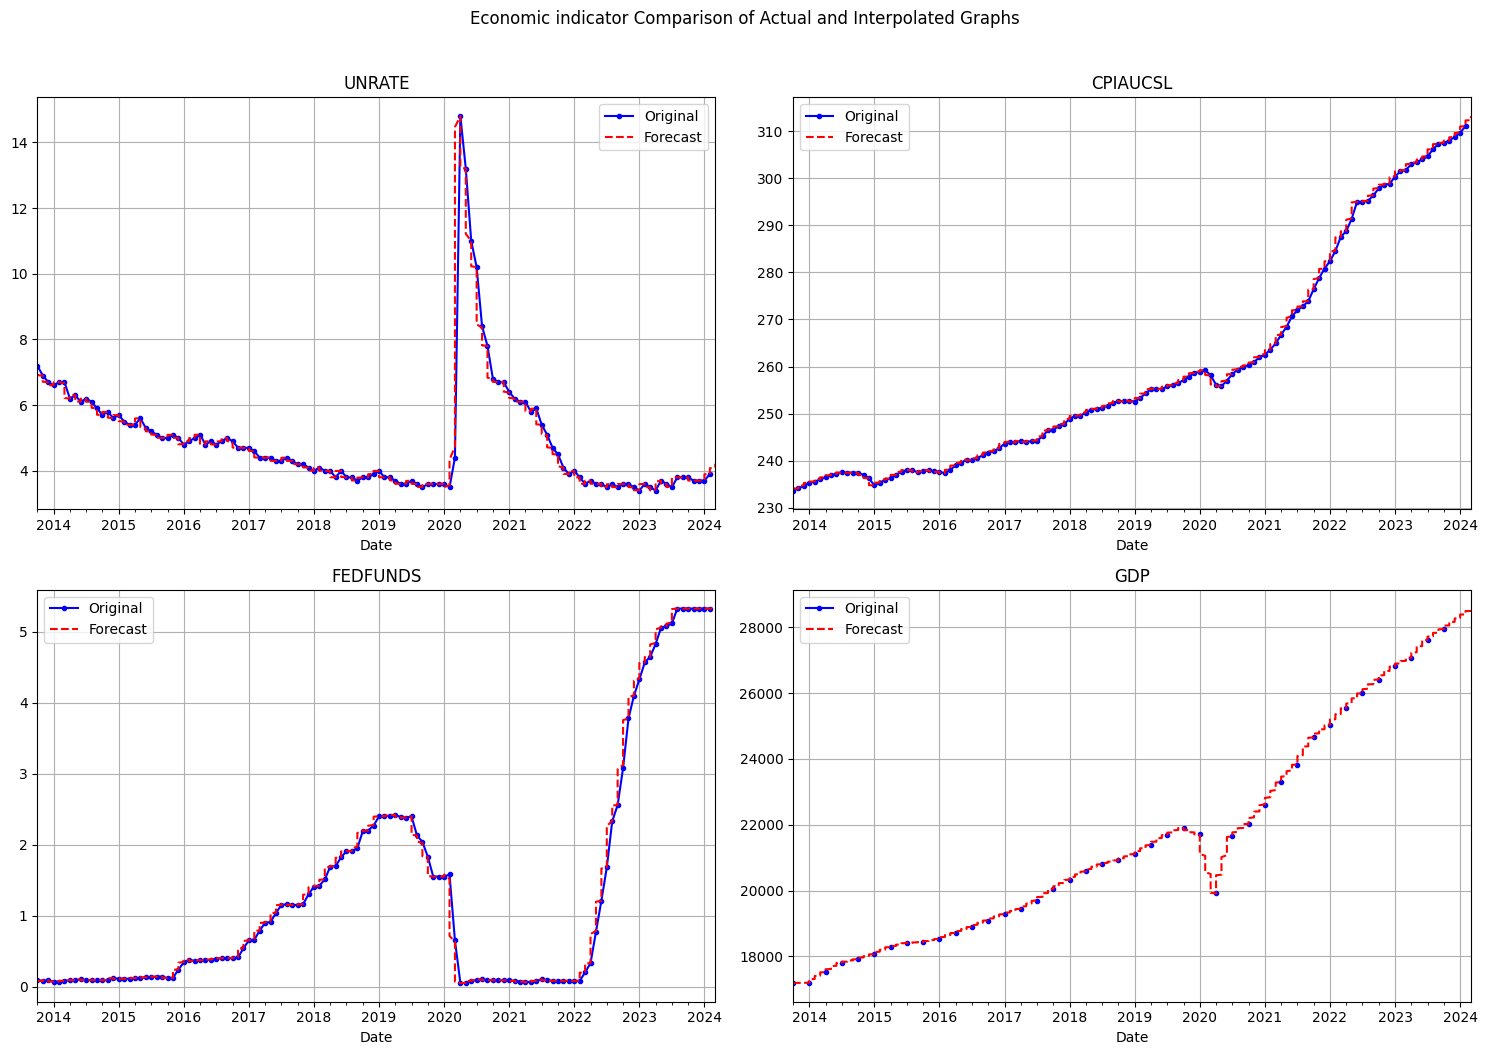

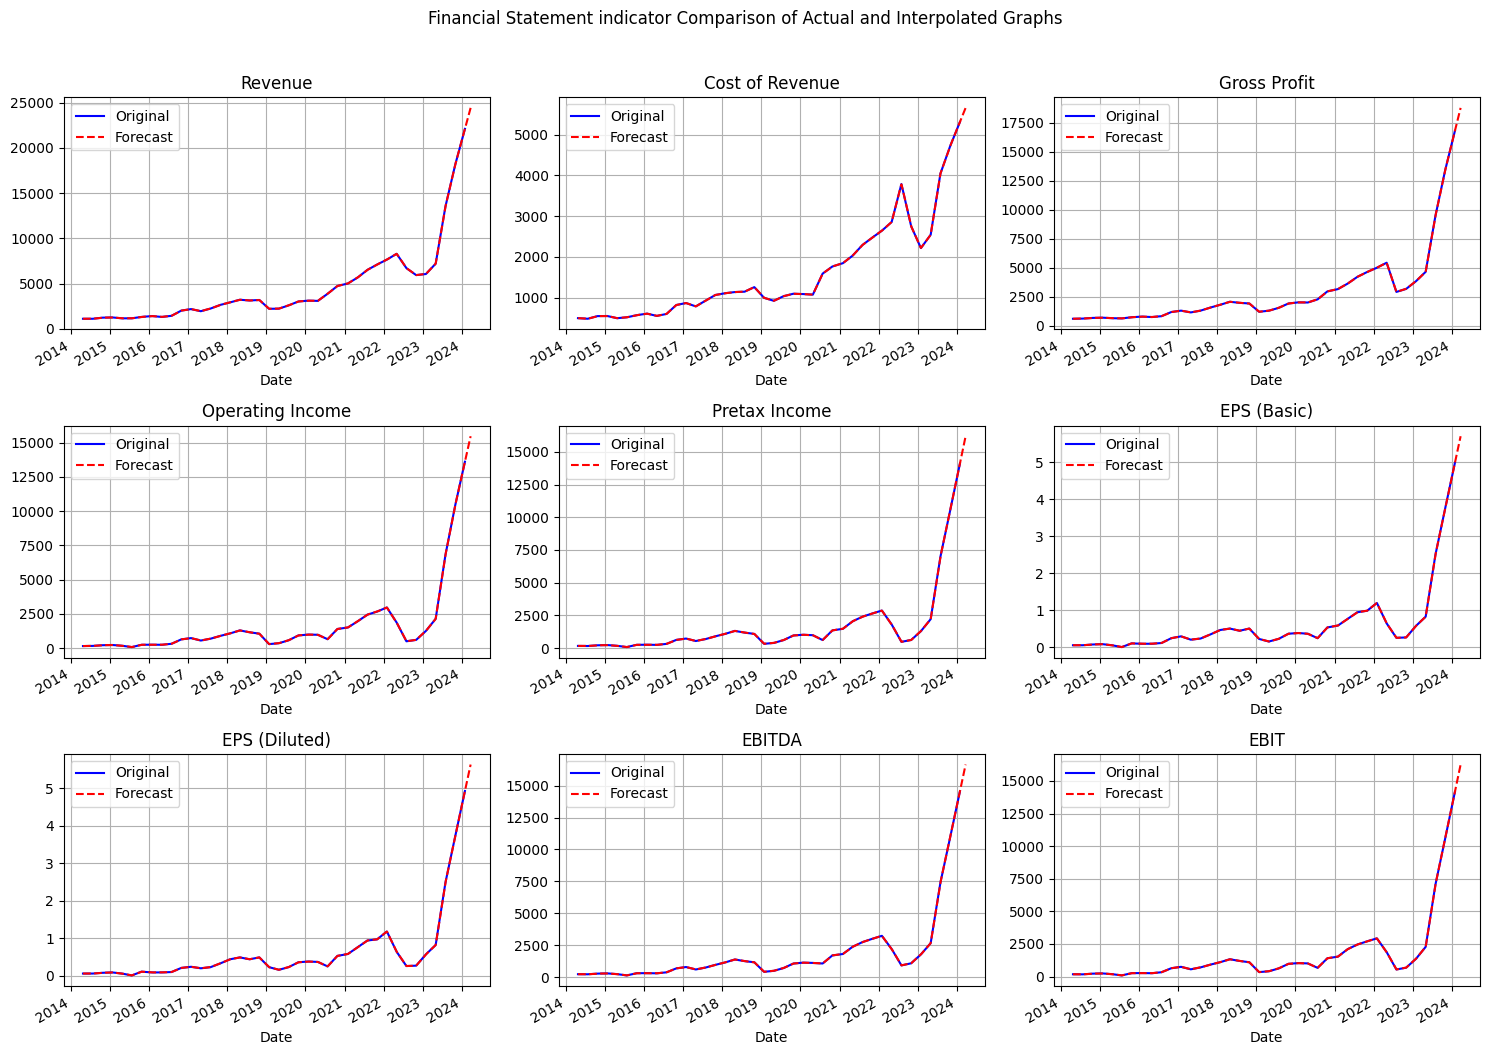

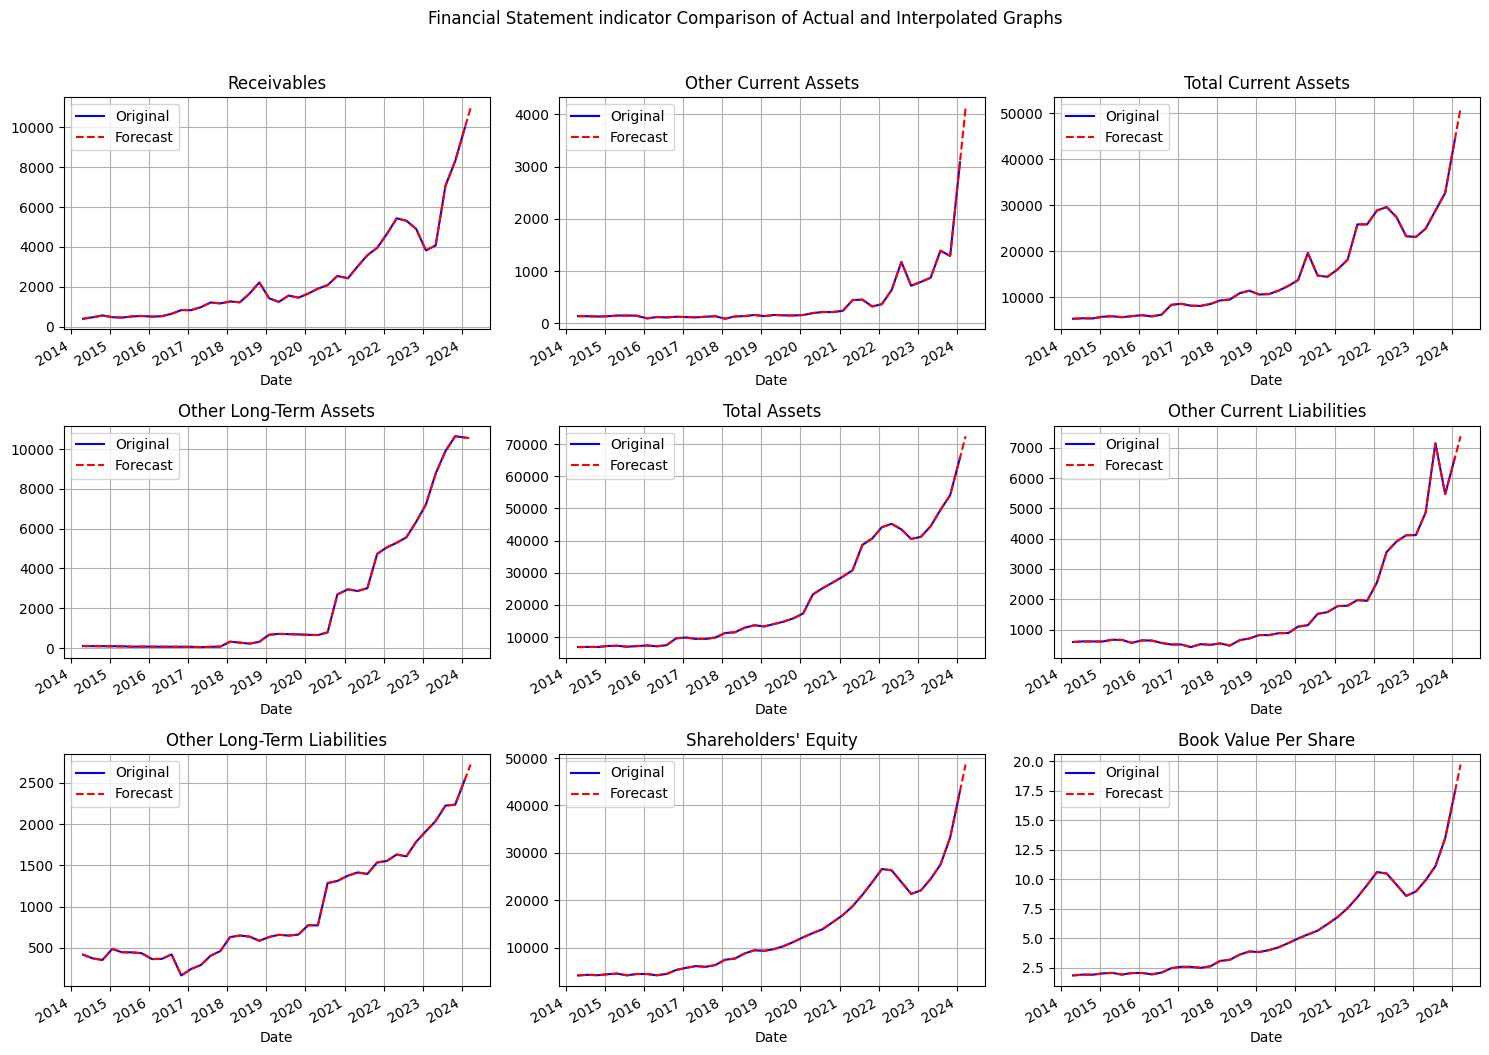

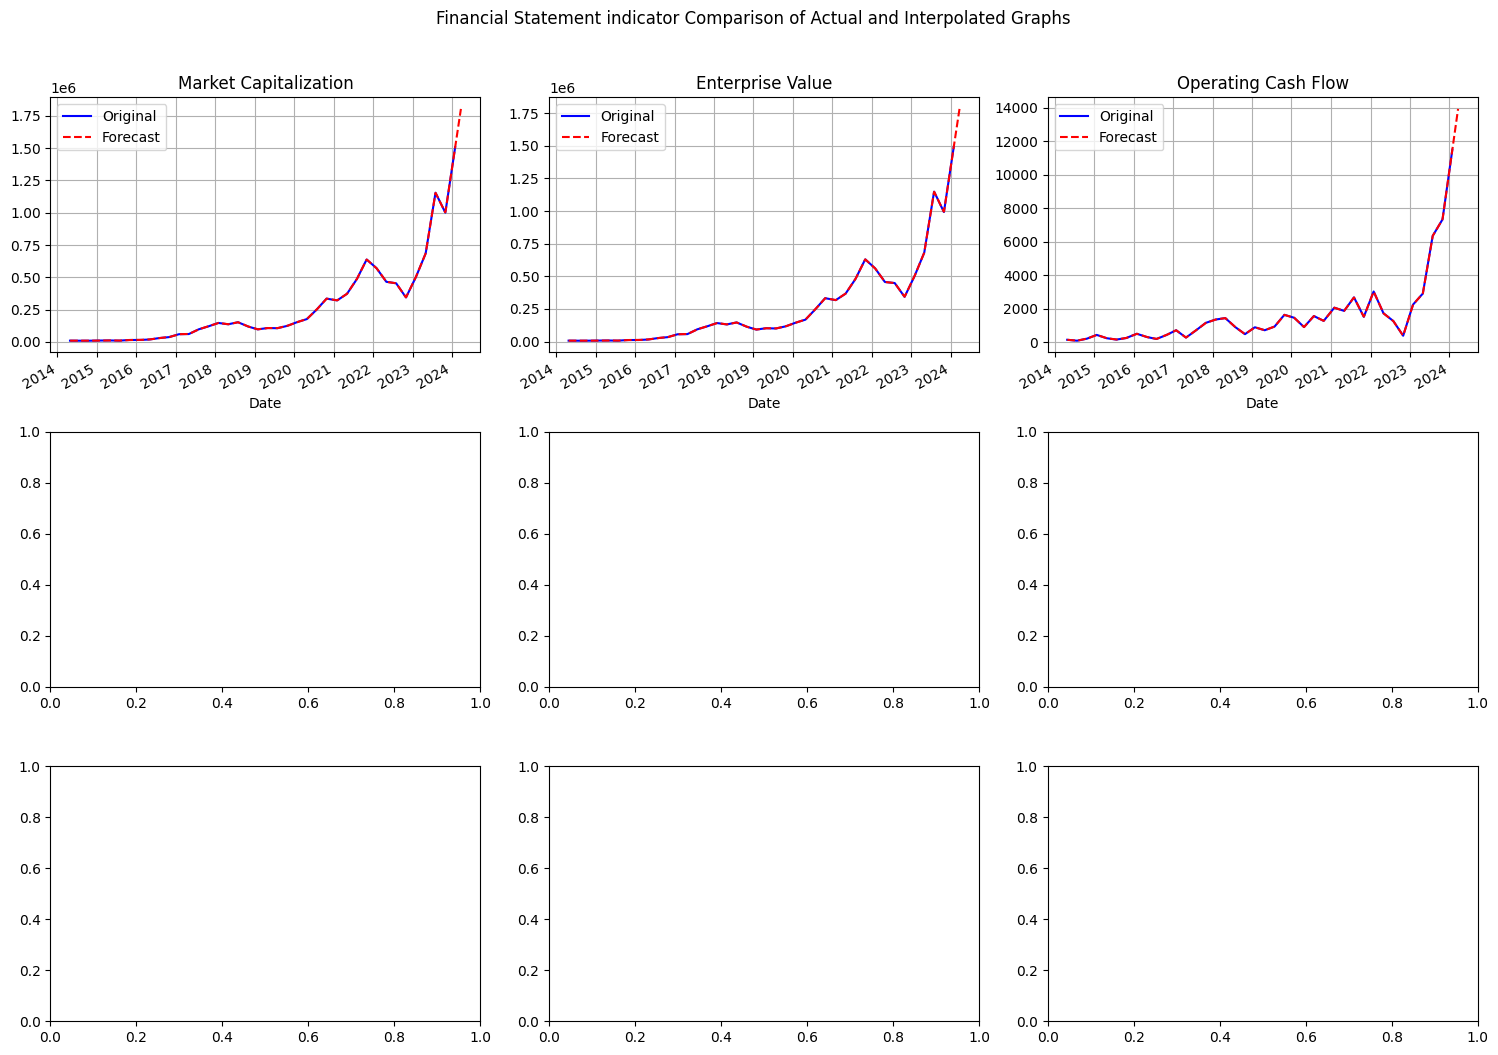

In [9]:
# 1. Economic Indicators plot comparison

# 월별 경제 지표 데이터프레임을 결합합니다.
econ_month_df = Unemployment_Rate.join([CPI, FEDFUNDS, GDP], how='left')

# 2x2 서브플롯을 생성합니다.
fig, axes = plt.subplots(2, 2, figsize=(15, 10))  
axes = axes.ravel()

# 경제 지표 데이터프레임의 각 열에 대해 반복하여 시각화합니다.
for idx, column in enumerate(econ_month_df.columns):
    ax = axes[idx]
    
    # 실제 데이터를 파란색 실선으로 플로팅합니다.
    econ_month_df[column].plot(ax=ax, label='Original', linestyle='-', color='blue', marker='o', ms=3)
    
    # 예측된 데이터를 빨간색 점선으로 플로팅합니다.
    econ_df[column].plot(ax=ax, label='Forecast', linestyle='--', color='red')
    
    # 서브플롯 제목을 설정합니다.
    ax.set_title(column)
    
    # 범례를 표시합니다.
    ax.legend(loc='best')
    
    # 그리드를 표시합니다.
    ax.grid(True)

# 서브플롯 간 간격을 조정합니다.
plt.tight_layout()

# 전체 그래프의 제목을 설정합니다.
plt.suptitle('Economic indicator Comparison of Actual and Interpolated Graphs', y=1.05)

# 그래프를 표시합니다.
plt.show()

# 2. Financial Statement Indicators plot comparison

# 일반적인 열만 선택합니다.
common_columns = FS_Summary.columns.intersection(daily_FS_Summary.columns)

# 페이지당 그래프 수를 정의합니다.
page_size = 9

# 총 페이지 수를 계산합니다.
total_pages = -(-len(common_columns) // page_size)

# 각 페이지에 대해 반복합니다.
for page in range(total_pages):
    # 페이지당 그래프를 생성합니다.
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    axes = axes.ravel() 
    
    # 현재 페이지의 마지막 열 인덱스를 계산합니다.
    end_idx = min((page + 1) * page_size, len(common_columns))    
    
    # 현재 페이지의 열에 대해 반복합니다.
    for idx in range(page * page_size, end_idx):
        column = common_columns[idx]
        
        # 실제 데이터를 파란색 실선으로 플로팅합니다.
        FS_Summary[column].plot(ax=axes[idx % page_size], label='Original', linestyle='-', color='blue')
        
        # 예측된 데이터를 빨간색 점선으로 플로팅합니다.
        daily_FS_Summary[column].plot(ax=axes[idx % page_size], label='Forecast', linestyle='--', color='red')
        
        # 서브플롯 제목을 설정합니다.
        axes[idx % page_size].set_title(column)
        
        # 범례를 표시합니다.
        axes[idx % page_size].legend(loc='best')
        
        # 그리드를 표시합니다.
        axes[idx % page_size].grid(True)
    
    # 서브플롯 간 간격을 조정합니다.
    plt.tight_layout()
    
    # 전체 그래프의 제목을 설정합니다.
    plt.suptitle('Financial Statement indicator Comparison of Actual and Interpolated Graphs', y=1.05)
    
    # 그래프를 표시합니다.
    plt.show()


## 5. 변수들과 수정종가간의 상관관계 시각화 및 변수 선택

['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA5', 'MA20', 'MA60', 'MA120', 'EMA5', 'EMA20', 'EMA60', 'EMA120', 'BOL_AVG', 'BOL_H1', 'BOL_L1', 'BOL_H2', 'BOL_L2']


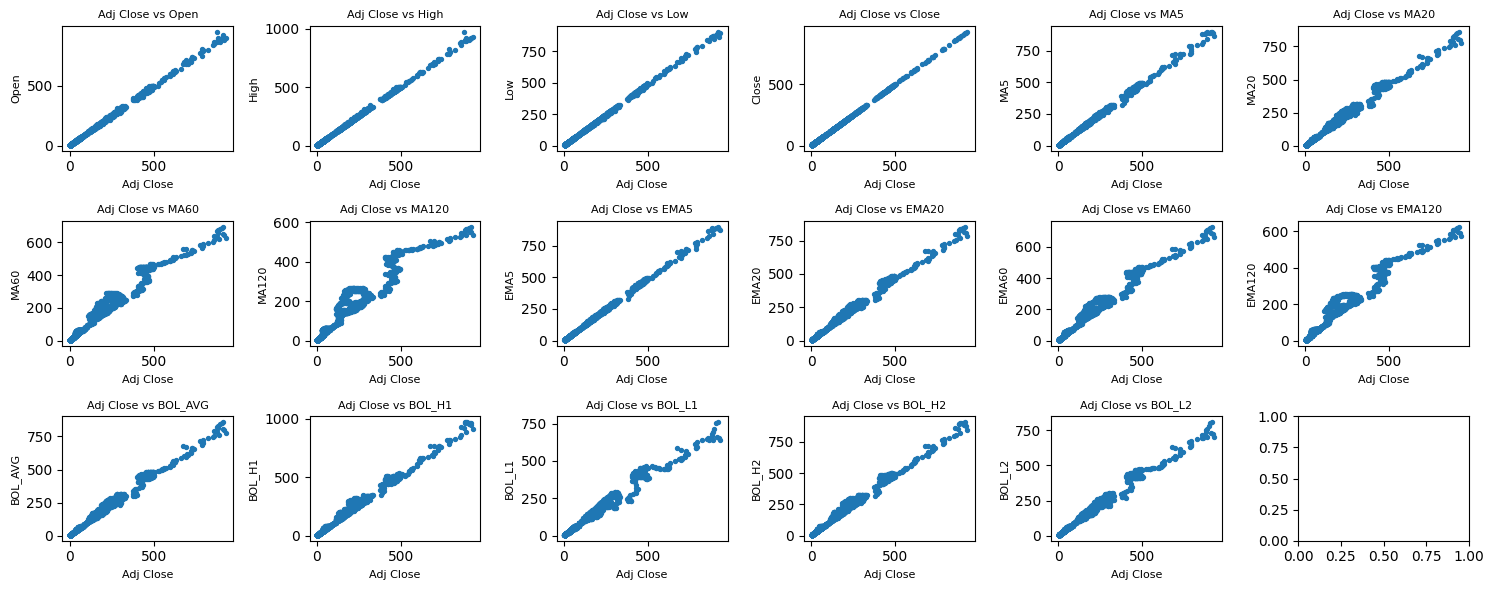

['Adj Close', 'CPIAUCSL', 'GDP']


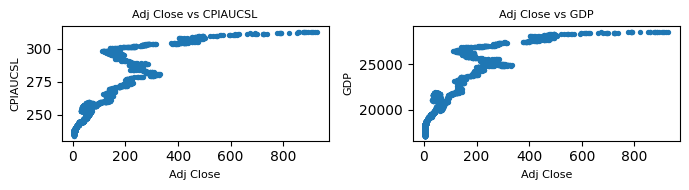

['Adj Close']


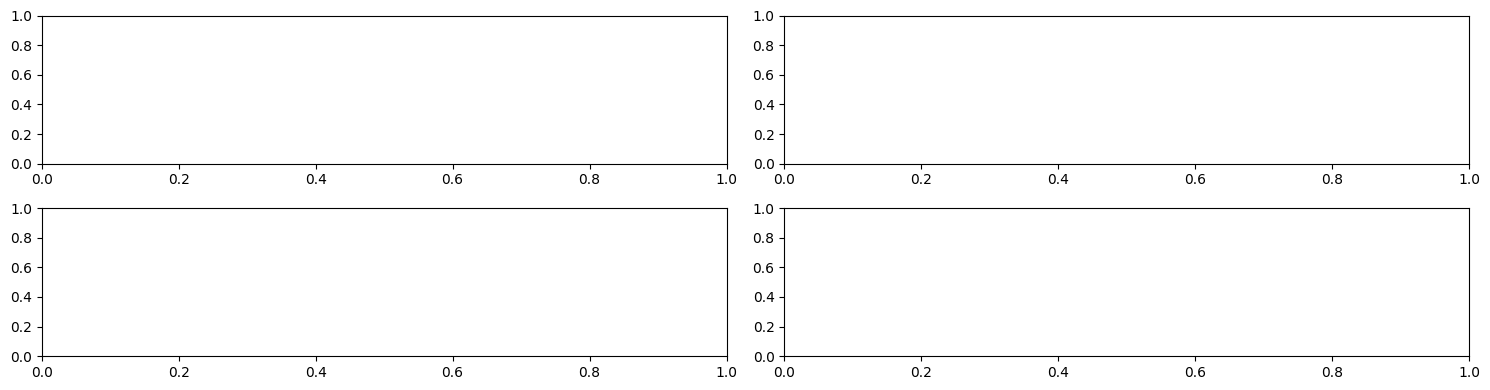

['Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Income', 'Pretax Income', 'EPS (Basic)', 'EPS (Diluted)', 'EBITDA', 'EBIT', 'Receivables', 'Other Current Assets', 'Total Current Assets', 'Other Long-Term Assets', 'Total Assets', 'Other Current Liabilities', 'Other Long-Term Liabilities', "Shareholders' Equity", 'Book Value Per Share', 'Market Capitalization', 'Enterprise Value', 'Operating Cash Flow', 'Adj Close']


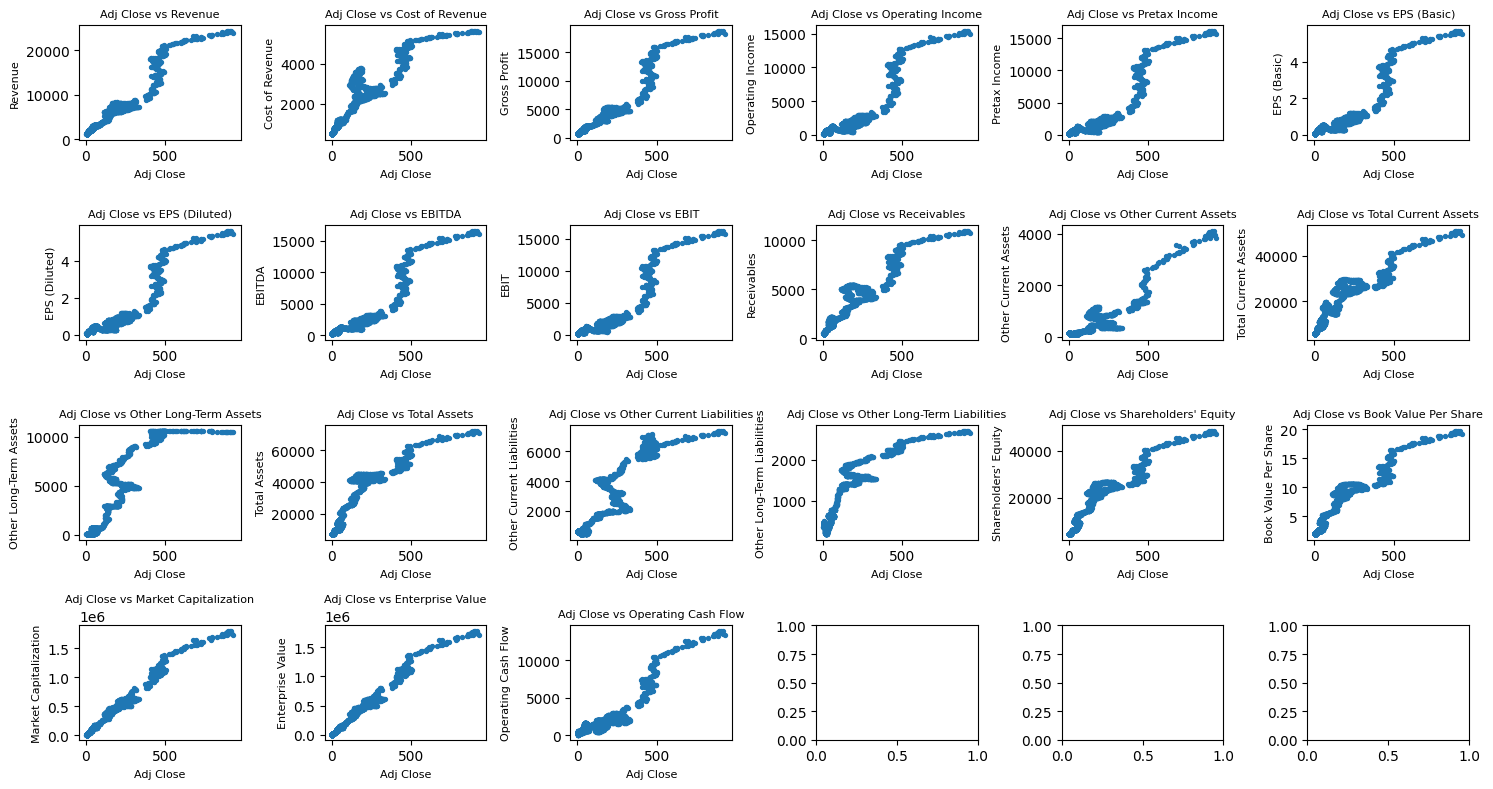

In [10]:
### Technical Feature Selection

# 1.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = stock_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 1.2. Correlation Graph against Adj Close
ncols = 6  
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(stock_df['Adj Close'], stock_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 1.3. Select features based on high correlation
tech_df = stock_df[selected_features]


### Fundamental Feature Selection

## Economic Variable Selection
# 2.1. Filter features with a correlation coefficient of 0.8 or higher
correlation = econ_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.8].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 2.2. Correlation Graph against Adj Close
ncols = 2  
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(econ_df['Adj Close'], econ_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 2.3. Select features based on high correlation
econ_df = econ_df[selected_features]

## Industry Variable Selection
# 3.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = Industry_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 3.2.
ncols = 2  
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(Industry_df['Adj Close'], Industry_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 3.3. Select features based on high correlation
Industry_df = Industry_df[selected_features]

## Company Variable Selection
# 4.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 4.2.
ncols = 6  
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(daily_FS_Summary['Adj Close'], daily_FS_Summary[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 주가예측 분석


## 1. Technical Analysis - LSTM model

['Open', 'High', 'Low', 'Close', 'Adj Close', 'MA5', 'MA20', 'MA60', 'MA120', 'EMA5', 'EMA20', 'EMA60', 'EMA120', 'BOL_AVG', 'BOL_H1', 'BOL_L1', 'BOL_H2', 'BOL_L2']


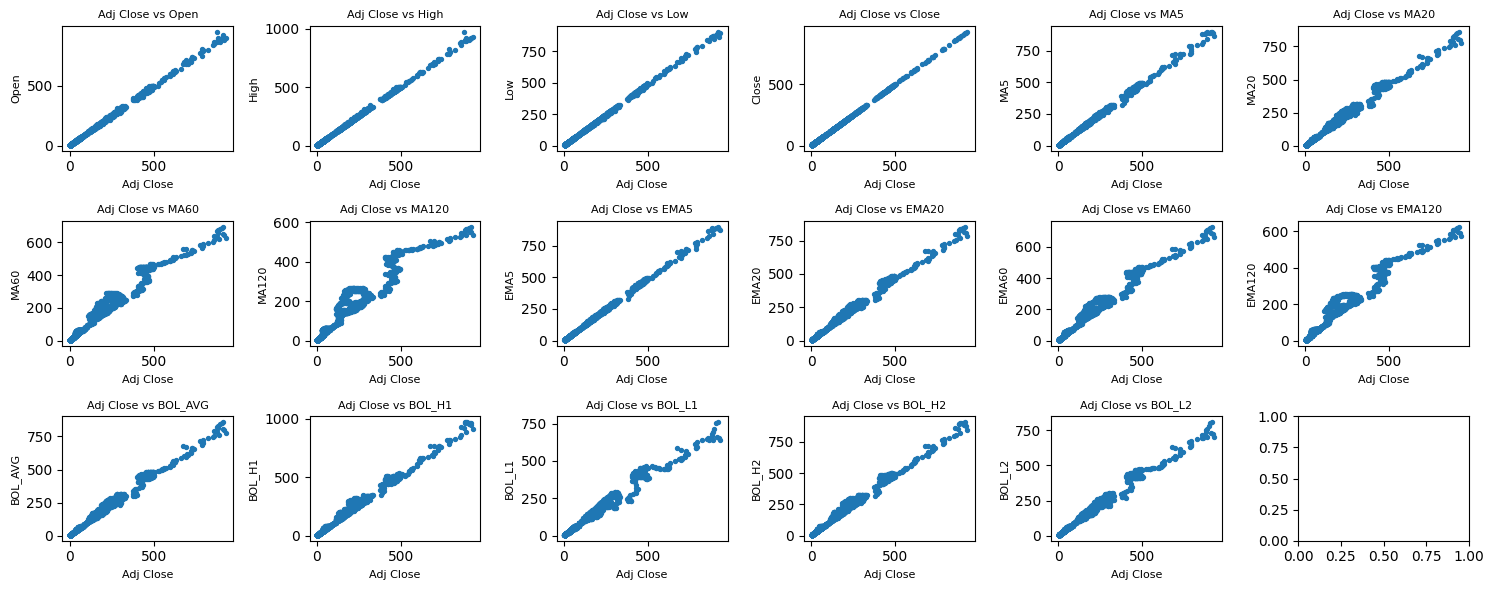

['Adj Close', 'CPIAUCSL', 'GDP']


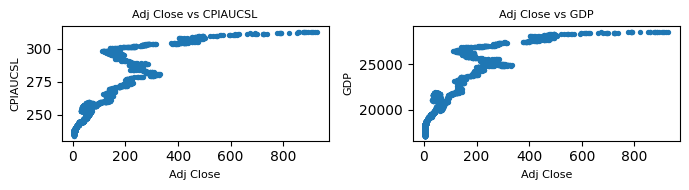

['Adj Close']


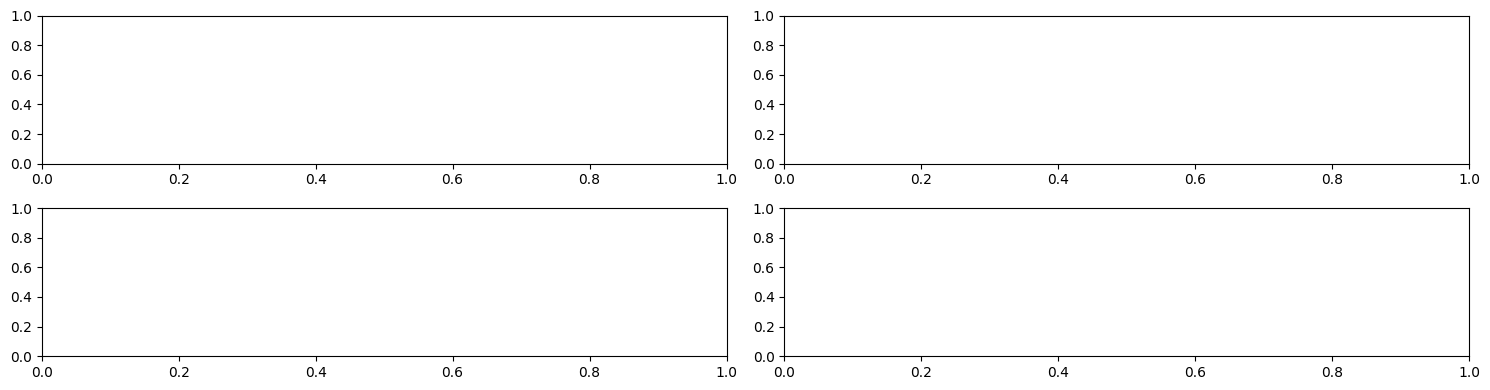

['Revenue', 'Cost of Revenue', 'Gross Profit', 'Operating Income', 'Pretax Income', 'EPS (Basic)', 'EPS (Diluted)', 'EBITDA', 'EBIT', 'Receivables', 'Other Current Assets', 'Total Current Assets', 'Other Long-Term Assets', 'Total Assets', 'Other Current Liabilities', 'Other Long-Term Liabilities', "Shareholders' Equity", 'Book Value Per Share', 'Market Capitalization', 'Enterprise Value', 'Operating Cash Flow', 'Adj Close']


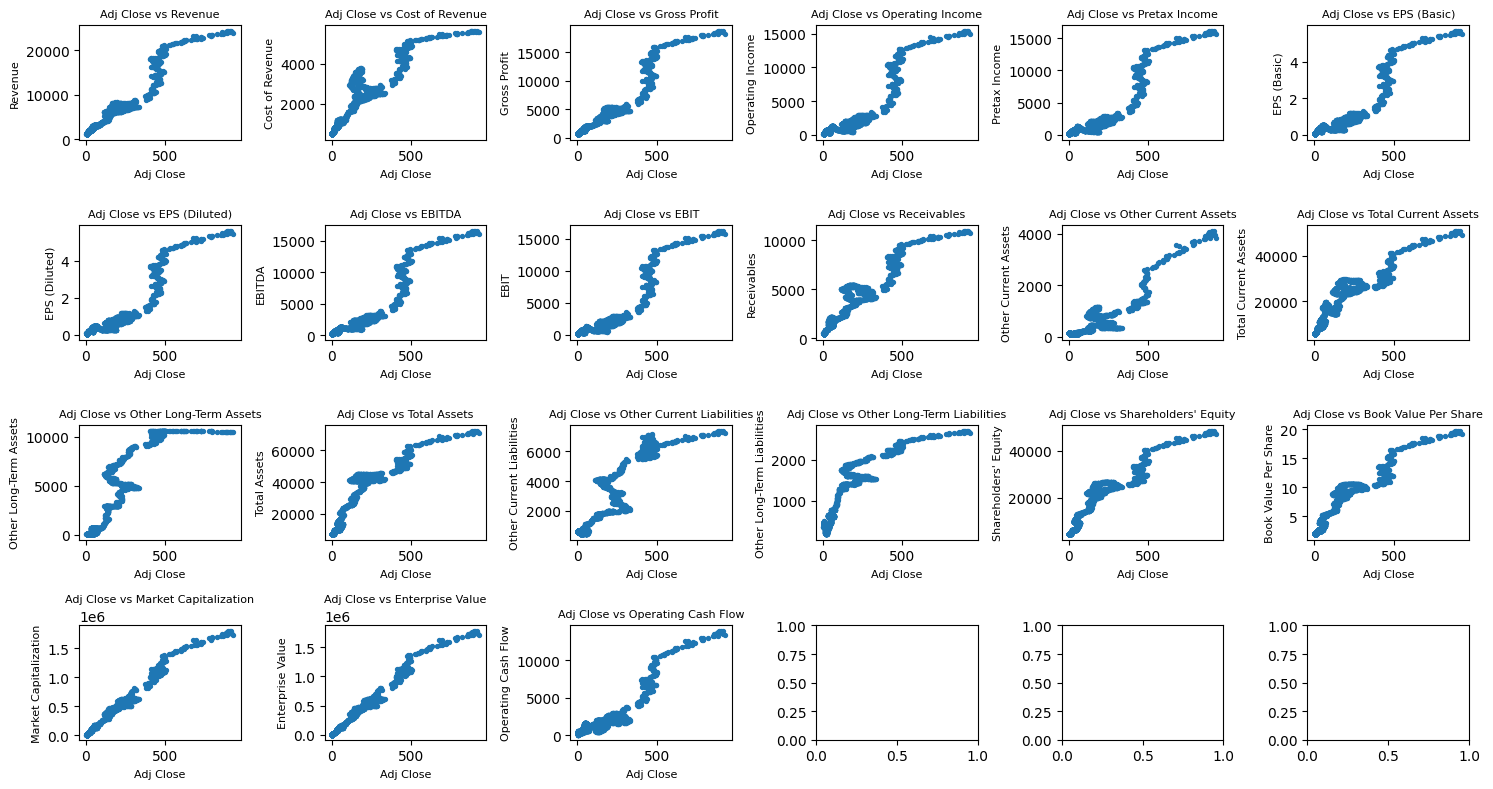

In [11]:
### Technical Feature Selection

# 1.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = stock_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 1.2. Correlation Graph against Adj Close
ncols = 6  
nrows = 3
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(stock_df['Adj Close'], stock_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 1.3. Select features based on high correlation
tech_df = stock_df[selected_features]


### Fundamental Feature Selection

## Economic Variable Selection
# 2.1. Filter features with a correlation coefficient of 0.8 or higher
correlation = econ_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.8].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 2.2. Correlation Graph against Adj Close
ncols = 2  
nrows = 1
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(7, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(econ_df['Adj Close'], econ_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 2.3. Select features based on high correlation
econ_df = econ_df[selected_features]

## Industry Variable Selection
# 3.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = Industry_df.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 3.2.
ncols = 2  
nrows = 2
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(Industry_df['Adj Close'], Industry_df[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

# 3.3. Select features based on high correlation
Industry_df = Industry_df[selected_features]

## Company Variable Selection
# 4.1. Filter features with a correlation coefficient of 0.9 or higher
correlation = daily_FS_Summary.corr()['Adj Close']
selected_features = correlation[correlation.abs() > 0.9].index.tolist() 
selected_features2 = selected_features.copy()
selected_features2.remove('Adj Close')
print(selected_features) 

# 4.2.
ncols = 6  
nrows = 4
fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 2*nrows))
for ax, feature in zip(axes.ravel(), selected_features2):
    ax.scatter(daily_FS_Summary['Adj Close'], daily_FS_Summary[feature], s=8) 
    ax.set_title(f'Adj Close vs {feature}', fontsize=8)
    ax.set_xlabel('Adj Close', fontsize=8)
    ax.set_ylabel(feature, fontsize=8)
plt.tight_layout()
plt.show()

In [12]:
## 1.1. Load data and Remove Missing value
df = tech_df

df = df.dropna()
df.isnull().sum() 

## 1.2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = df.columns.tolist()
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Define Input Parameter: feature, label -> numpy type
def make_sequene_dataset(feature, label, window_size):
    feature_list = []      
    label_list = []        
    for i in range(len(feature)-window_size):
        feature_list.append(feature[i:i+window_size]) 
        label_list.append(label[i+window_size]) 
    return np.array(feature_list), np.array(label_list) 

# Create feature_df, label_df 
feature_cols = df.columns.drop('Adj Close').tolist()
label_cols = [ 'Adj Close' ]

feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# DataFrame -> Numpy transform
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

print(f'feature_np.shape:{feature_np.shape}')
print(f'label_np.shape:{label_np.shape}')

feature_np.shape:(2498, 17)
label_np.shape:(2498, 1)


In [13]:
## 1.3. Create data    
# Set window size
window_size = 30
X, Y = make_sequene_dataset(feature_np, label_np, window_size)

# 3.2. Split into train, test (8:2)
split = int(len(X)*0.80) 
x_train = X[0:split]
y_train = Y[0:split]

x_test = X[split:]
y_test = Y[split:]

print(f'X.shape:{X.shape}, Y.shape:{Y.shape}')
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}')
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') 


X.shape:(2468, 30, 17), Y.shape:(2468, 1)
x_train.shape:(1974, 30, 17), y_train.shape:(1974, 1)
x_test.shape:(494, 30, 17), y_test.shape:(494, 1)


In [14]:
## 1.4. Construct and Compile model
model = Sequential()

model.add(LSTM(64, activation='tanh', input_shape=x_train[0].shape, return_sequences=False, 
               kernel_regularizer=L1L2(l1=0.0001, l2=0.0001), recurrent_regularizer=L1L2(l1=0.0001, l2=0.0001)))
model.add(Dropout(0.2))

model.add(Dense(1, activation='linear'))

model.compile(loss='mse', optimizer='adam', metrics=['mae'])

model.summary()

# List to record the loss values during the model training process
train_loss_history = []
val_loss_history = []

# Train model (Apply earlystopping)
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

hist = model.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=1000, batch_size=150,       
          callbacks=[early_stop]) 

pred = model.predict(x_test)



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 64)                20992     
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 21057 (82.25 KB)
Trainable params: 21057 (82.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000


14/14 [==============================] - 2s 46ms/step - loss: 0.1234 - mae: 0.0630 - val_loss: 0.1176 - val_mae: 0.0894
Epoch 2/1000
14/14 [==============================] - 0s 12ms/step - loss: 0.0976 - mae: 0.0232 - val_loss: 0.0888 - val_mae: 0.0460
Epoch 3/1000
1

### 1.2. Technical model Accuracy test


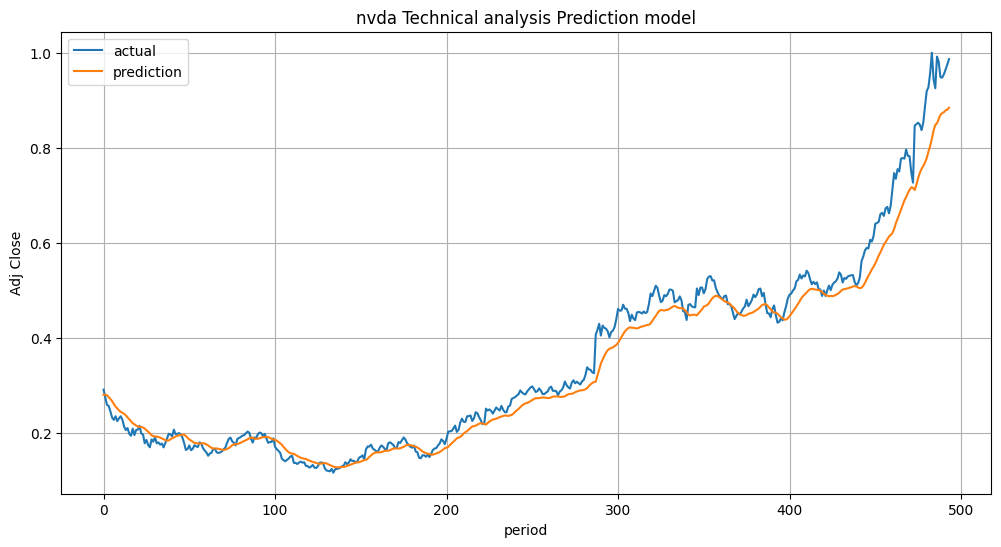

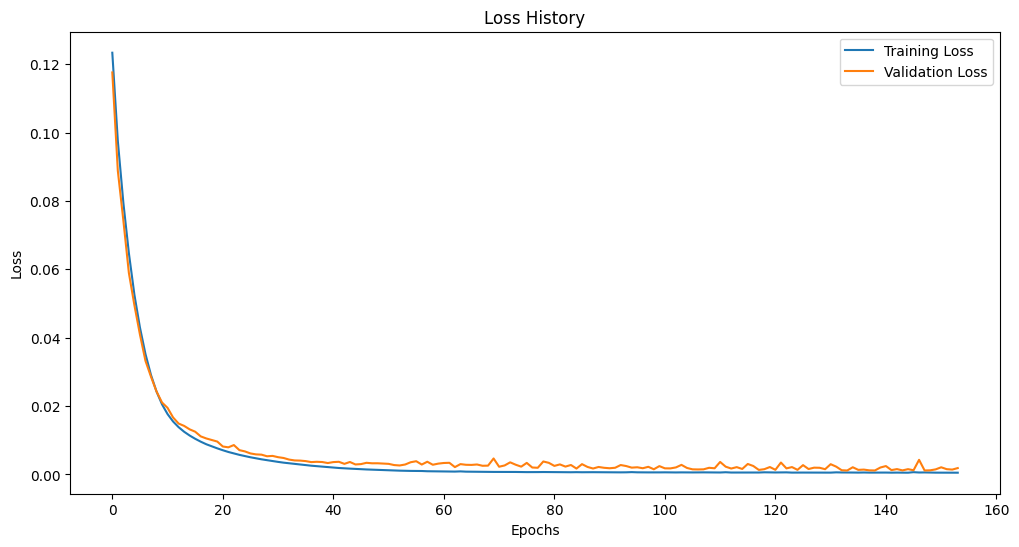

  Metrics    Values
0    MAPE  0.071485
1     MAE  0.026645
2    RMSE  0.038472


In [15]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Technical analysis Prediction model')
plt.ylabel('Adj Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()

# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

# Evaluation 2: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

### 1.3. DataFrame for use as input to the Stacking model


In [16]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

tech_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

### 1.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [17]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3)  
else:
    next_day = last_date + pd.Timedelta(days=1)  

# 1. Extract the last 30 days data
recent_feature = feature_np[-window_size:]
recent_feature = recent_feature.reshape(1, window_size, -1)

# 2. Predict the value for the next day
predicted_new = model.predict(recent_feature)

# 3. Inverse transform the predicted value to its original scale
dummy_data = np.zeros((1, scaled_df.shape[1] - 1))
predicted_new_full_features = np.hstack([predicted_new, dummy_data])

tech_predicted_new_original = scaler.inverse_transform(predicted_new_full_features)[0, 0]

1/1 [==============================] - 0s 16ms/step


## 2. Fundamental Analysis - LSTM model


In [18]:
# 경제 데이터, 산업 데이터, 일일 재무 요약 데이터를 각각 로드
df = econ_df
df2 = Industry_df.drop(columns=['Adj Close']) # 산업 데이터에서 'Adj Close' 컬럼 제거
df3 = daily_FS_Summary.drop(columns=['Adj Close']) # 일일 재무 요약 데이터에서 'Adj Close' 컬럼 제거

# 날짜를 기준으로 세 데이터프레임을 병합. 'left' 조인을 사용해 df의 모든 행을 유지
df = df.merge(df2, on='Date', how='left')
df = df.merge(df3, on='Date', how='left')

# 결측치를 포함한 행 제거
df = df.dropna()
# 모든 컬럼에 대해 결측치가 없는지 확인 (결과는 출력되지 않음)
df.isnull().sum() 

# MinMaxScaler 인스턴스 생성
scaler = MinMaxScaler()
# 데이터프레임의 모든 컬럼을 리스트로 변환
scale_cols = df.columns.tolist()
# 정규화를 적용할 컬럼을 선택하여 데이터를 변환
scaled_df = scaler.fit_transform(df[scale_cols])
# 정규화된 데이터를 다시 데이터프레임으로 변환하고, 컬럼 이름 재지정
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 


# 시퀀스 데이터셋을 생성하는 함수 정의
def make_sequene_dataset(feature, label, window_size):
    feature_list = [] # 특성 데이터를 저장할 리스트
    label_list = [] # 라벨 데이터를 저장할 리스트
    # 전체 데이터 길이에서 윈도우 크기를 뺀 만큼 반복
    for i in range(len(feature)-window_size):
        # 현재 인덱스에서 윈도우 크기만큼의 특성 데이터를 추출하여 feature_list에 추가
        feature_list.append(feature[i:i+window_size]) 
        # 현재 인덱스에서 윈도우 크기를 더한 위치의 라벨 데이터를 label_list에 추가
        label_list.append(label[i+window_size]) 
    # 리스트를 numpy 배열로 변환하여 반환
    return np.array(feature_list), np.array(label_list) 


# 'Adj Close'를 제외한 모든 컬럼을 특성으로 선택
feature_cols = df.columns.drop('Adj Close').tolist()
# 'Adj Close' 컬럼만 라벨로 선택
label_cols = ['Adj Close']

# 정규화된 데이터프레임에서 특성 컬럼만 선택하여 새로운 데이터프레임 생성
feature_df = pd.DataFrame(scaled_df, columns=feature_cols)
# 정규화된 데이터프레임에서 라벨 컬럼만 선택하여 새로운 데이터프레임 생성
label_df = pd.DataFrame(scaled_df, columns=label_cols)

# 데이터프레임을 numpy 배열로 변환
feature_np = feature_df.to_numpy()
label_np = label_df.to_numpy()

# 변환된 numpy 배열의 차원을 출력
print(f'feature_np.shape:{feature_np.shape}') # 특성 데이터의 형태 출력
print(f'label_np.shape:{label_np.shape}') # 라벨 데이터의 형태 출력


feature_np.shape:(2493, 23)
label_np.shape:(2493, 1)


In [19]:
# 윈도우 크기를 설정. 이 크기는 시퀀스 데이터셋을 생성할 때 사용됩니다.
window_size = 30
# 앞서 정의한 함수를 사용해 시계열 데이터를 시퀀스로 변환합니다.
# feature_np는 모델의 입력으로 사용될 특성 데이터, label_np는 예측 대상인 라벨 데이터입니다.
# 반환된 X, Y는 각각 변환된 특성과 라벨 데이터의 시퀀스를 나타냅니다.
X, Y = make_sequene_dataset(feature_np, label_np, window_size)


# 전체 데이터셋 중에서 80%를 훈련 데이터로 사용하기 위한 분할 지점을 계산합니다.
split = int(len(X)*0.80)
# 분할 지점을 기준으로 훈련 데이터와 라벨을 할당합니다.
x_train = X[0:split] # 분할 지점까지의 데이터를 훈련 데이터로 사용
y_train = Y[0:split] # 분할 지점까지의 라벨을 훈련 라벨로 사용

# 분할 지점 이후의 데이터를 테스트 데이터와 라벨로 할당합니다.
x_test = X[split:] # 분할 지점 이후의 데이터를 테스트 데이터로 사용
y_test = Y[split:] # 분할 지점 이후의 라벨을 테스트 라벨로 사용

# 변환된 데이터셋의 차원과 분할 후 훈련 및 테스트 데이터셋의 차원을 출력합니다.
# 이를 통해 데이터셋의 구조와 크기를 확인할 수 있습니다.
print(f'X.shape:{X.shape}, Y.shape:{Y.shape}') # 전체 시퀀스 데이터셋의 형태
print(f'x_train.shape:{x_train.shape}, y_train.shape:{y_train.shape}') # 훈련 데이터셋의 형태
print(f'x_test.shape:{x_test.shape}, y_test.shape:{y_test.shape}') # 테스트 데이터셋의 형태


X.shape:(2463, 30, 23), Y.shape:(2463, 1)
x_train.shape:(1970, 30, 23), y_train.shape:(1970, 1)
x_test.shape:(493, 30, 23), y_test.shape:(493, 1)


In [20]:
# Sequential 모델 인스턴스 생성
model = Sequential()

# 첫 번째 LSTM 층 추가
model.add(LSTM(128, # LSTM 층의 뉴런(유닛) 수. 성능과 과적합에 영향을 줄 수 있는 하이퍼파라미터입니다.
               activation='tanh', # 활성화 함수. 'tanh'는 LSTM에서 일반적으로 좋은 성능을 내는 활성화 함수입니다.
               input_shape=x_train[0].shape, # 입력 데이터의 형태. 첫 층에 필요한 파라미터입니다.
               return_sequences=True, # 다음 층이 LSTM 층인 경우 True로 설정. 마지막 LSTM 층에서는 False.
               kernel_regularizer=L1L2(l1=0.001, l2=0.001), # 가중치에 대한 L1, L2 정규화. 과적합 방지에 도움을 줍니다.
               recurrent_regularizer=L1L2(l1=0.001, l2=0.001))) # 재귀적 가중치에 대한 L1, L2 정규화.

model.add(Dropout(0.2)) # 과적합 방지를 위한 Dropout 층. 0.2는 무작위로 20%의 뉴런을 비활성화.

# 두 번째 LSTM 층 추가
model.add(LSTM(64, # 뉴런 수. 첫 번째 LSTM 층보다 낮은 값으로 설정하여 모델의 복잡도를 조절합니다.
               activation='tanh')) # 활성화 함수. 여기서도 'tanh' 사용.
model.add(Dropout(0.2)) # 두 번째 Dropout 층.

# 출력 층 추가
model.add(Dense(1, activation='linear')) # 예측 값을 출력하기 위한 Dense 층. 활성화 함수로 'linear' 사용.

# 모델 컴파일
model.compile(loss='mse', # 손실 함수로 평균 제곱 오차(MSE) 사용. 연속적인 값을 예측하는 회귀 문제에 적합.
              optimizer='adam', # 최적화 알고리즘으로 Adam 사용. 일반적으로 좋은 성능을 보임.
              metrics=['mae']) # 성능 평가 지표로 평균 절대 오차(MAE) 사용.

# 모델 구조 요약 출력
model.summary()


# 훈련 손실과 검증 손실을 기록할 리스트 초기화
train_loss_history = []
val_loss_history = []


# 조기 종료(Early Stopping) 콜백 설정. 검증 손실이 20 에폭 동안 개선되지 않으면 훈련을 멈춤.
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

# 모델 훈련
hist = model.fit(x_train, y_train, # 훈련 데이터와 라벨
                 validation_data=(x_test, y_test), # 검증 데이터와 라벨
                 epochs=1000, # 최대 에폭 수. 큰 값으로 설정하되, Early Stopping을 통해 조절될 수 있음.
                 batch_size=150, # 배치 크기. 한 번에 처리할 데이터의 수. 메모리 사용량과 훈련 속도에
      
          callbacks=[early_stop]) 

pred = model.predict(x_test)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 30, 128)           77824     
                                                                 
 dropout_1 (Dropout)         (None, 30, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_2 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 127297 (497.25 KB)
Trainable params: 127297 (497.25 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/1000
1

### 2.2. Fundamental model Accuracy test

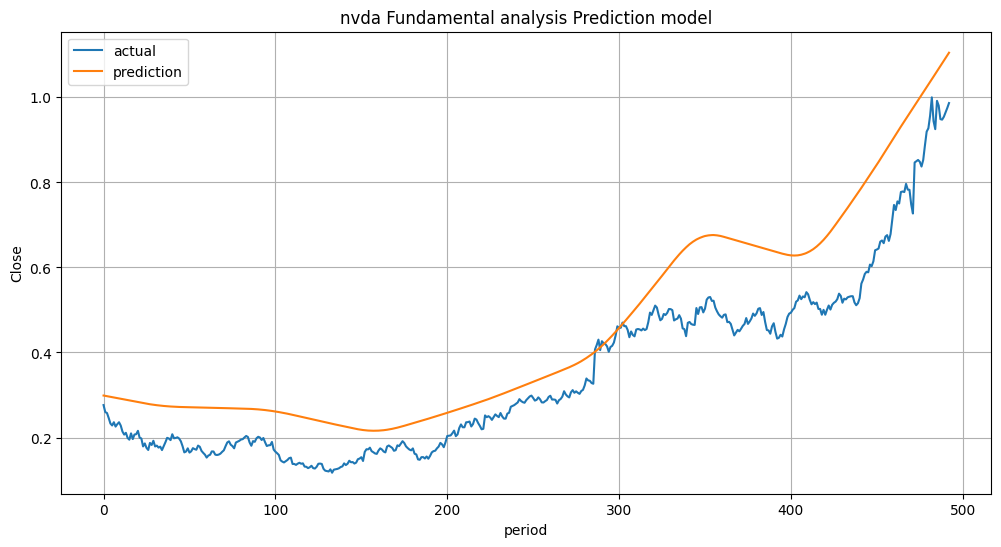

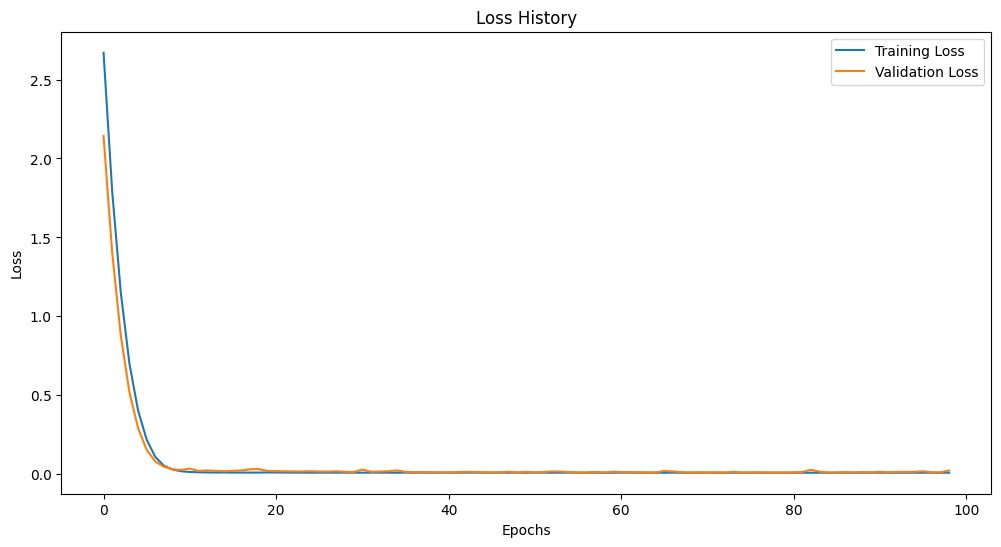

  Metrics    Values
0    MAPE  0.351445
1     MAE  0.102559
2    RMSE  0.117296


In [21]:
# Evaluation 1: Prediction Graph
plt.figure(figsize=(12, 6))
plt.title(f'{ticker} Fundamental analysis Prediction model')
plt.ylabel('Close')
plt.xlabel('period')
plt.plot(y_test, label='actual')
plt.plot(pred, label='prediction')
plt.grid()
plt.legend(loc='best')
plt.show()


# Evaluation 2: Learning Curve
train_loss_history.extend(hist.history['loss']) 
val_loss_history.extend(hist.history['val_loss'])

plt.figure(figsize=(12, 6))
plt.plot(train_loss_history, label='Training Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.legend()
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()


# Evaluation 3: MAPE, MAE, RMSE
mape = np.sum(abs(y_test - pred) / y_test) / len(x_test)
mae = np.mean(np.abs(y_test - pred))
rmse = np.sqrt(np.mean(np.square(y_test - pred)))

metrics_df = pd.DataFrame({
    'Metrics': ['MAPE', 'MAE', 'RMSE'],
    'Values': [mape, mae, rmse]})

print(metrics_df)

### 2.3. DataFrame for use as input to the Stacking model(스태킹 모델에 대한 입력으로 사용하기 위한 DataFrame)


In [22]:
inverse_df = pd.DataFrame(np.zeros((len(y_test), len(scale_cols))), columns=scale_cols) 
inverse_df['Adj Close'] = y_test.flatten()
real_y_test = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

inverse_df['Adj Close'] = pred.flatten() 
real_pred = scaler.inverse_transform(inverse_df)[:, inverse_df.columns.get_loc('Adj Close')]

dates = df.index[split+window_size:].values 

fund_result_df = pd.DataFrame({
    'Date': dates,
    'Real Price': real_y_test,
    'Predicted Price': real_pred
})

### 2.4. Predicting the actual next day's adjusted closing price based on the Technical model

In [23]:
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4:  
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1) 

# 1. Extract the last 50 days data
latest_data = feature_np[-window_size:]
latest_data = latest_data.reshape(1, window_size, -1)

# 2. Predict the value for the next day
next_day_pred = model.predict(latest_data)

# 3. Inverse transform the predicted value to its original scale
inverse_df_temp = pd.DataFrame(np.zeros((1, len(scale_cols))), columns=scale_cols)  
inverse_df_temp['Adj Close'] = next_day_pred.flatten()
fund_predicted_new_original = scaler.inverse_transform(inverse_df_temp)[:, inverse_df_temp.columns.get_loc('Adj Close')]

# Convert numpy array value to scalar
fund_predicted_new_original = fund_predicted_new_original.item()

1/1 [==============================] - 0s 14ms/step


## 3. 최종예측을 위한 Stacking model 생성 (XGBoost, GridSearchCV)

### 3.1. 데이터 준비 및 전처리


In [24]:

# 1. Create dataframe based on each analysis result
df = pd.merge(tech_result_df[['Date', 'Real Price', 'Predicted Price']], 
                     fund_result_df[['Date', 'Predicted Price']],
                     on='Date', 
                     how='inner', 
                     suffixes=('_Tech', '_Fund'))

df.columns = ['Date', 'Real Price', 'Tech_Pred', 'Fund_Pred'] # Rename Column
df = df.set_index('Date').sort_index()

# 2. Apply MinMax Normalization
scaler = MinMaxScaler()
scale_cols = ['Real Price', 'Tech_Pred', 'Fund_Pred']
scaled_df = scaler.fit_transform(df[scale_cols])
scaled_df = pd.DataFrame(scaled_df, columns=scale_cols) 

# Create Feature/Label for Stacking model
X_stack = scaled_df[['Tech_Pred', 'Fund_Pred']].values
y_stack = scaled_df['Real Price'].values

# 3. Data split (20% test)
X_train, X_val, y_train, y_val = train_test_split(X_stack, y_stack, test_size=0.2, random_state=42)

print(f'X_train.shape:{X_train.shape}, X_val.shape:{X_val.shape}')
print(f'y_train.shape:{y_train.shape}, y_val.shape:{y_val.shape}') 


X_train.shape:(394, 2), X_val.shape:(99, 2)
y_train.shape:(394,), y_val.shape:(99,)


### 3.2. Meta model result visualization(메타 모델 결과 시각화)


In [25]:
# 4. Meta model training using XGBoost with GridSearchCV
model = xgb.XGBRegressor(objective='reg:squarederror')

param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'subsample': [0.8, 0.9],
    'colsample_bytree': [0.8, 0.9],
    'n_estimators': [50, 100],
    'gamma': [0, 0.1, 0.2],
    'min_child_weight': [1, 5, 10],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0.5, 1, 1.5]
}

grid_search = GridSearchCV(model, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print(f"Best parameters found: {best_params}")

# Train the model with best parameters
meta_model_xgb = xgb.XGBRegressor(objective='reg:squarederror', **best_params)
meta_model_xgb.fit(X_train, y_train)

y_pred = meta_model_xgb.predict(X_val)


Best parameters found: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 1, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 1, 'subsample': 0.9}


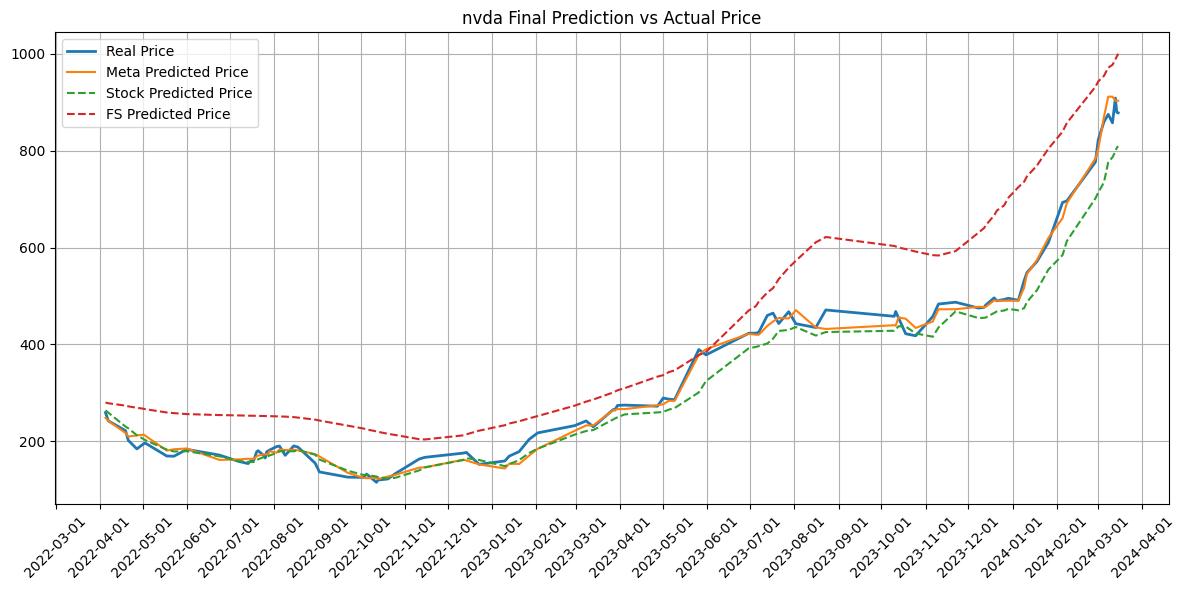

In [26]:
# Extracting predicted values from scaled data
y_val_original = scaler.inverse_transform(np.column_stack([y_val, np.zeros_like(y_val), np.zeros_like(y_val)]))[:, 0]
y_pred_original = scaler.inverse_transform(np.column_stack([y_pred, np.zeros_like(y_pred), np.zeros_like(y_pred)]))[:, 0]
tech_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), X_val[:, 0], np.zeros_like(y_pred)]))[:, 1]
fund_pred_original = scaler.inverse_transform(np.column_stack([np.zeros_like(y_pred), np.zeros_like(y_pred), X_val[:, 1]]))[:, 2]

# Extracting date index
date_train, date_val = train_test_split(df.index, test_size=0.2, random_state=42)

# Prediction Graph
plot_df = pd.DataFrame({
    'Date': date_val,
    'Real Price': y_val_original,
    'Meta Predicted Price': y_pred_original,
    'Stock Predicted Price': tech_pred_original,
    'FS Predicted Price': fund_pred_original
})

plot_df = plot_df.sort_values(by='Date')
plot_df['Date'] = pd.to_datetime(plot_df['Date'])

plt.figure(figsize=(12, 6))
plt.plot(plot_df['Date'], plot_df['Real Price'], label='Real Price', linewidth=2)
plt.plot(plot_df['Date'], plot_df['Meta Predicted Price'], label='Meta Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['Stock Predicted Price'], '--', label='Stock Predicted Price', linewidth=1.5)
plt.plot(plot_df['Date'], plot_df['FS Predicted Price'], '--', label='FS Predicted Price', linewidth=1.5)

ax = plt.gca() 
ax.xaxis.set_major_locator(mdates.MonthLocator(interval=1)) 
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))  

plt.title(f"{ticker} Final Prediction vs Actual Price")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)  
plt.tight_layout()  


train_mse: 0.00018278294647715155, val_mse: 0.00036091419242570476


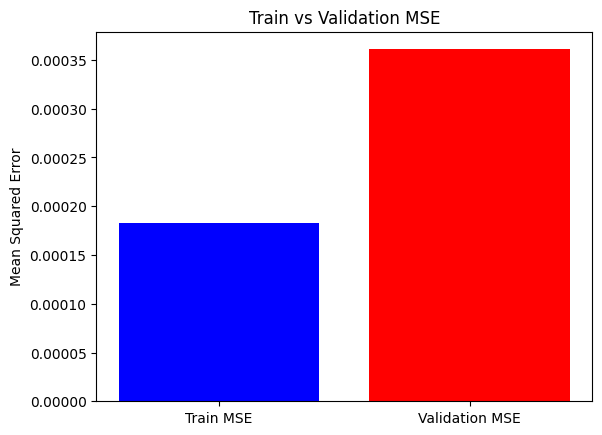

val_mse: 0.00036091419242570476, cross_val_mse: 0.010024674319237375


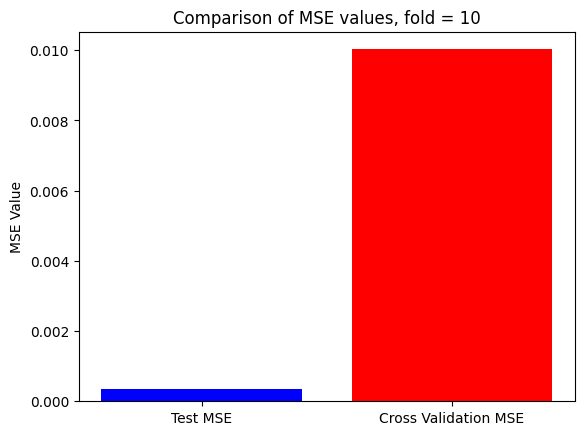

In [27]:
# 1. MSE Comparison Graph for train and validation set
y_train_pred = meta_model_xgb.predict(X_train)
train_mse = mean_squared_error(y_train, y_train_pred)
val_mse = mean_squared_error(y_val, y_pred)
print( f'train_mse: {train_mse}, val_mse: {val_mse}')

plt.bar(['Train MSE', 'Validation MSE'], [train_mse, val_mse], color=['blue', 'red'])
plt.ylabel('Mean Squared Error')
plt.title('Train vs Validation MSE')
plt.show()

# 2.  MSE Comparison Graph using cross validation for validation and cv validation (fold =10)
cross_val_mse = -cross_val_score(meta_model_xgb, X_stack, y_stack, cv=10, scoring='neg_mean_squared_error').mean()
errors = [val_mse, cross_val_mse]
labels = ['Test MSE', 'Cross Validation MSE']
print( f'val_mse: {val_mse}, cross_val_mse: {cross_val_mse}')

plt.bar(labels, errors, color=['blue', 'red'])
plt.ylabel('MSE Value')
plt.title('Comparison of MSE values, fold = 10')
plt.show()

### 3.4. Predicting the actual price for the next day

In [28]:
# Predicted values for the next day obtained from the Technical and Fundamental models
next_day_tech_pred = tech_predicted_new_original  
next_day_fund_pred = fund_predicted_new_original 

next_day_tech_pred_scaled = scaler.transform([[0, next_day_tech_pred, 0]])[0][1]  
next_day_fund_pred_scaled = scaler.transform([[0, 0, next_day_fund_pred]])[0][2]  

# Predict with trained stacking model
next_day_meta_pred_scaled = meta_model_xgb.predict(np.array([[next_day_tech_pred_scaled, next_day_fund_pred_scaled]]))[0]
next_day_meta_pred = scaler.inverse_transform([[next_day_meta_pred_scaled, 0, 0]])[0][0]

# Print the date of the next day
last_date = pd.to_datetime(df.index[-1]) 

if last_date.weekday() == 4: 
    next_day = last_date + pd.Timedelta(days=3) 
else:
    next_day = last_date + pd.Timedelta(days=1)  

print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Tech 예측 가격은: {next_day_tech_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 Funda 예측 가격은: {next_day_fund_pred}") 
print(f"다음 날({next_day.strftime('%Y-%m-%d')})의 최종 예측 가격은: {next_day_meta_pred}") 

다음 날(2024-03-22)의 Tech 예측 가격은: 848.0296859662693
다음 날(2024-03-22)의 Funda 예측 가격은: 1029.3442629726485
다음 날(2024-03-22)의 최종 예측 가격은: 903.9912878776212
